## MNIST Fashion with CNN 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root="./data/fashion",
    train=True,
    transform=transform,
    download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data/fashion",
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(
    train_dataset,[train_size,val_size]
)

batch_size = 128

train_loader = DataLoader(train_dataset,batch_size,True)
val_loader = DataLoader(val_dataset,batch_size,True)
test_loader = DataLoader(test_dataset,batch_size,True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 307kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.48MB/s]


In [4]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1529, 0.2353, 0.2000,
           0.2235, 0.1961, 0.2157, 0.2078, 0.1961, 0.1922, 0.1647, 0.1725,
           0.1804, 0.1843, 0.2353, 0.0431],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.5216, 0.6196, 0.5922,
           0.7529, 0.7725, 0.8118, 0.7882, 

In [ ]:
class simple_mlp(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,32)
        self.fc5 = nn.Linear(32,10)
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x              



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_mlp().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 10e-3,
)

simple_mlp(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)


In [5]:
def train_one_epoch(model,optimizer,criterion,loader,device):
    model.train()
    running_loss = 0.0

    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs=model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss/len(loader.dataset)
    return epoch_loss       

In [6]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()*images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
    val_loss = running_loss / len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return val_loss,accuracy

In [31]:
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,loader=train_loader,
        optimizer=optimizer,criterion=criterion,
        device=device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/10] Train Loss: 0.5970 Val Loss: 0.4528 Val Acc: 0.8332
Epoch [2/10] Train Loss: 0.4195 Val Loss: 0.3913 Val Acc: 0.8635
Epoch [3/10] Train Loss: 0.3818 Val Loss: 0.4109 Val Acc: 0.8573
Epoch [4/10] Train Loss: 0.3657 Val Loss: 0.3997 Val Acc: 0.8642
Epoch [5/10] Train Loss: 0.3523 Val Loss: 0.4039 Val Acc: 0.8563
Epoch [6/10] Train Loss: 0.3359 Val Loss: 0.3812 Val Acc: 0.8668
Epoch [7/10] Train Loss: 0.3279 Val Loss: 0.3774 Val Acc: 0.8695
Epoch [8/10] Train Loss: 0.3214 Val Loss: 0.3894 Val Acc: 0.8665
Epoch [9/10] Train Loss: 0.3123 Val Loss: 0.3597 Val Acc: 0.8742
Epoch [10/10] Train Loss: 0.3090 Val Loss: 0.3737 Val Acc: 0.8702


In [7]:
def plot_curves(train_losses,val_losses,val_accuracies):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")

    plt.show()


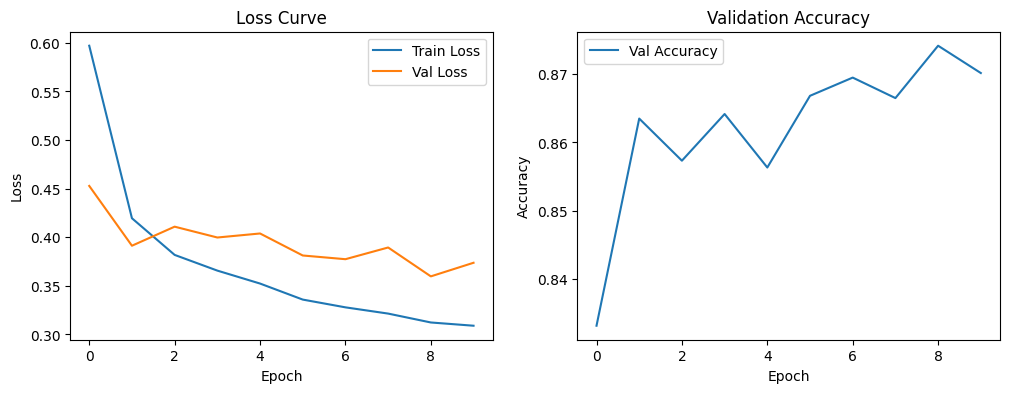

In [33]:
plot_curves(train_losses,val_losses,val_accuracies)

In [9]:
class simple_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3)
        self.conv3 = nn.Conv2d(64,64,kernel_size=3)
        self.conv4 = nn.Conv2d(64,128,kernel_size=3,padding=1,stride=2)
        self.max1 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*6*6,128)
        self.fc2 = nn.Linear(128,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max1(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_cnn().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 10e-3,
)

simple_cnn(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
num_epochs = 15

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,loader=train_loader,
        optimizer=optimizer,criterion=criterion,
        device=device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/15] Train Loss: 0.6014 Val Loss: 0.3675 Val Acc: 0.8655
Epoch [2/15] Train Loss: 0.3359 Val Loss: 0.3428 Val Acc: 0.8663
Epoch [3/15] Train Loss: 0.3001 Val Loss: 0.3241 Val Acc: 0.8747
Epoch [4/15] Train Loss: 0.2852 Val Loss: 0.2885 Val Acc: 0.8940
Epoch [5/15] Train Loss: 0.2629 Val Loss: 0.2901 Val Acc: 0.8927
Epoch [6/15] Train Loss: 0.2517 Val Loss: 0.2959 Val Acc: 0.8923
Epoch [7/15] Train Loss: 0.2389 Val Loss: 0.2882 Val Acc: 0.8965
Epoch [8/15] Train Loss: 0.2347 Val Loss: 0.3260 Val Acc: 0.8878
Epoch [9/15] Train Loss: 0.2273 Val Loss: 0.2947 Val Acc: 0.8970
Epoch [10/15] Train Loss: 0.2227 Val Loss: 0.2771 Val Acc: 0.9020
Epoch [11/15] Train Loss: 0.2143 Val Loss: 0.2956 Val Acc: 0.9002
Epoch [12/15] Train Loss: 0.2293 Val Loss: 0.2943 Val Acc: 0.9005
Epoch [13/15] Train Loss: 0.2023 Val Loss: 0.3097 Val Acc: 0.9000
Epoch [14/15] Train Loss: 0.1969 Val Loss: 0.3038 Val Acc: 0.9027
Epoch [15/15] Train Loss: 0.1942 Val Loss: 0.3059 Val Acc: 0.8972


In [8]:
def evaluate_on_test(model, loader, device):
    model.eval()
    correct=0
    all_preds=[]
    all_labels=[]
    with torch.no_grad():
        for images,labels in loader:
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)

            preds=outputs.argmax(dim=1)

            correct+=(preds==labels).sum().item()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    accuracy=correct/len(loader.dataset)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return accuracy,all_preds,all_labels

In [13]:
test_acc,test_preds,test_labels = evaluate_on_test(
    model,test_loader,device
)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8922


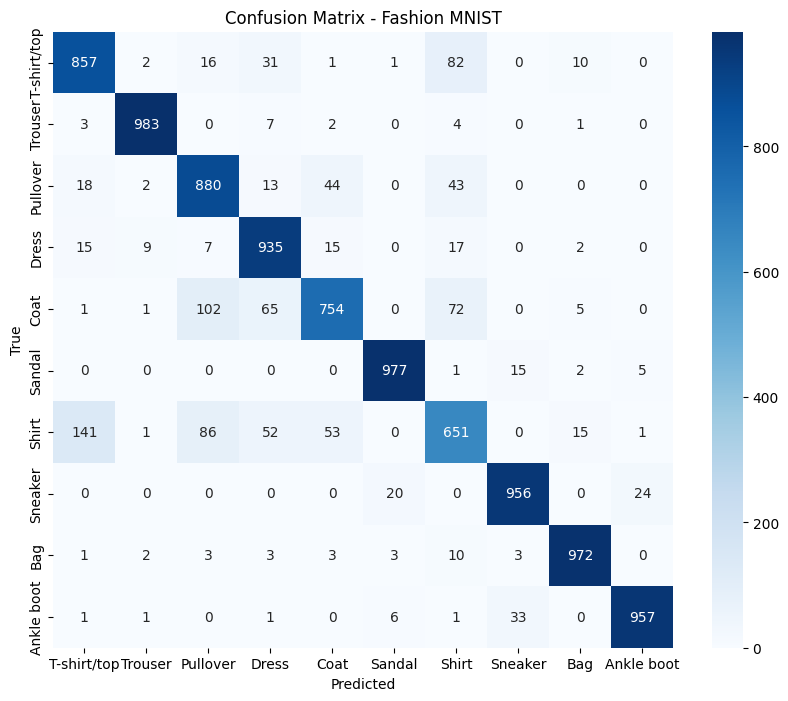

In [14]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8)) # Slightly larger to fit text labels
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=class_names, # Set X-axis labels
    yticklabels=class_names  # Set Y-axis labels
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fashion MNIST")
plt.show()

In [15]:
class simple_cnn_activations(simple_cnn):
    def forward(self,x):
        activations = {}
        x = F.relu(self.conv1(x))
        activations["conv1"] = x
        #x = self.drop(x)
        x = F.relu(self.conv2(x))
        activations["conv2"] = x
        #x = self.drop(x)
        x = F.relu(self.conv3(x))
        activations["conv3"] = x
        x = F.relu(self.conv4(x))
        activations["conv4"] = x
        x = self.max1(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, activations




In [16]:
def visualize_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)

    _, activations = model(image)

    for name, act in activations.items():
        act = act.cpu().detach()
        num_maps = min(16, act.shape[1])
        plt.figure(figsize=(12,1))
        for i in range(num_maps):
            plt.subplot(1, num_maps, i + 1)
            plt.imshow(act[0, i], cmap="gray")
            plt.axis("off")
            plt.suptitle(name)
    plt.show()


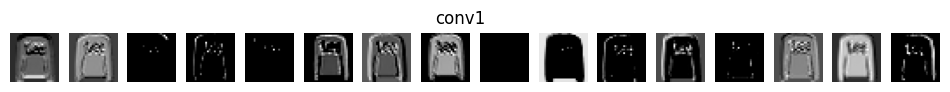

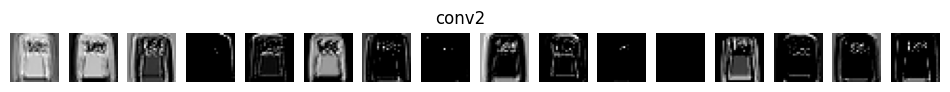

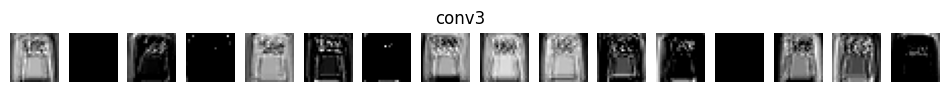

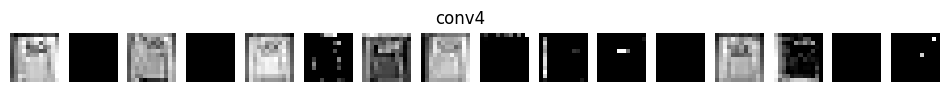

In [17]:
cnn_with_activations = simple_cnn_activations().to(device)

sample_img, label = test_dataset[1]
visualize_feature_maps(cnn_with_activations, sample_img)

In [33]:
class CNN_Elite(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Block 1: Feature Extraction
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.2)

        # Block 2: Deep Representation
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.3)

        # Block 3: The "GAP" transition (The Secret Sauce)
        # Instead of Flattening 128*7*7, we condense each map to 1 value
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected (Much smaller input now: just 128!)
        self.fc1 = nn.Linear(128, 256)
        self.drop3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1 - Using Mish for better gradient flow
        x = F.mish(self.bn1(self.conv1(x)))
        x = F.mish(self.bn2(self.conv2(x)))
        x = self.drop1(self.pool1(x))
        
        # Block 2
        x = F.mish(self.bn3(self.conv3(x)))
        x = F.mish(self.bn4(self.conv4(x)))
        x = self.drop2(self.pool2(x))
        
        # Transition
        x = self.gap(x) # Output: [Batch, 128, 1, 1]
        x = x.view(x.size(0), -1) # Flatten: [Batch, 128]
        
        # Fully Connected
        x = F.mish(self.fc1(x))
        x = self.drop3(x)
        return self.fc2(x)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_enhanced().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 10e-3,
)

cnn_enhanced(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.25, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [35]:
num_epochs = 15

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,loader=train_loader,
        optimizer=optimizer,criterion=criterion,
        device=device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/15] Train Loss: 0.8869 Val Loss: 0.5816 Val Acc: 0.7855
Epoch [2/15] Train Loss: 0.5605 Val Loss: 0.4480 Val Acc: 0.8452
Epoch [3/15] Train Loss: 0.4681 Val Loss: 0.4027 Val Acc: 0.8612
Epoch [4/15] Train Loss: 0.4062 Val Loss: 0.3310 Val Acc: 0.8825
Epoch [5/15] Train Loss: 0.3739 Val Loss: 0.3128 Val Acc: 0.8880
Epoch [6/15] Train Loss: 0.3502 Val Loss: 0.2980 Val Acc: 0.8948
Epoch [7/15] Train Loss: 0.3327 Val Loss: 0.2868 Val Acc: 0.8970
Epoch [8/15] Train Loss: 0.3171 Val Loss: 0.2644 Val Acc: 0.9045
Epoch [9/15] Train Loss: 0.3004 Val Loss: 0.2685 Val Acc: 0.9075
Epoch [10/15] Train Loss: 0.2896 Val Loss: 0.2411 Val Acc: 0.9128
Epoch [11/15] Train Loss: 0.2823 Val Loss: 0.2429 Val Acc: 0.9135
Epoch [12/15] Train Loss: 0.2803 Val Loss: 0.2595 Val Acc: 0.9015
Epoch [13/15] Train Loss: 0.2728 Val Loss: 0.2349 Val Acc: 0.9130
Epoch [14/15] Train Loss: 0.2656 Val Loss: 0.2371 Val Acc: 0.9167
Epoch [15/15] Train Loss: 0.2606 Val Loss: 0.2585 Val Acc: 0.9045
